In [1]:
import qiskit
import qiskit_ibm_runtime
print(f"Qiskit version: {qiskit.__version__}")
print(f"Runtime version: {qiskit_ibm_runtime.__version__}")

Qiskit version: 2.1.0
Runtime version: 0.40.1


## 6교시 : Primitive inputs and outputs



아래 회로와 같이 양자 회로를 만들어봅시다.

![](img/ex11.png)

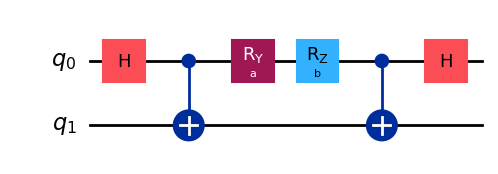

In [2]:
from qiskit.circuit import (
    Parameter,
    QuantumCircuit,
    ClassicalRegister,
    QuantumRegister,
)
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives.containers import BitArray

from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator
import numpy as np

# Define a circuit with two parameters.
circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(Parameter("a"), 0)
circuit.rz(Parameter("b"), 0)
circuit.cx(0, 1)
circuit.h(0)
circuit.draw('mpl')

Parameter에 들어갈 값을 지정합니다.

In [3]:
# "a" 와 "b" 의 값을 각각 100개씩 설정해줍니다.
params = np.vstack(
    [
        np.linspace(-np.pi, np.pi, 100),
        np.linspace(-4 * np.pi, 4 * np.pi, 100),
    ]
).T
print(params)

[[ -3.14159265 -12.56637061]
 [ -3.07812614 -12.31250454]
 [ -3.01465962 -12.05863847]
 [ -2.9511931  -11.8047724 ]
 [ -2.88772658 -11.55090632]
 [ -2.82426006 -11.29704025]
 [ -2.76079354 -11.04317418]
 [ -2.69732703 -10.7893081 ]
 [ -2.63386051 -10.53544203]
 [ -2.57039399 -10.28157596]
 [ -2.50692747 -10.02770988]
 [ -2.44346095  -9.77384381]
 [ -2.37999443  -9.51997774]
 [ -2.31652792  -9.26611167]
 [ -2.2530614   -9.01224559]
 [ -2.18959488  -8.75837952]
 [ -2.12612836  -8.50451345]
 [ -2.06266184  -8.25064737]
 [ -1.99919533  -7.9967813 ]
 [ -1.93572881  -7.74291523]
 [ -1.87226229  -7.48904915]
 [ -1.80879577  -7.23518308]
 [ -1.74532925  -6.98131701]
 [ -1.68186273  -6.72745093]
 [ -1.61839622  -6.47358486]
 [ -1.5549297   -6.21971879]
 [ -1.49146318  -5.96585272]
 [ -1.42799666  -5.71198664]
 [ -1.36453014  -5.45812057]
 [ -1.30106362  -5.2042545 ]
 [ -1.23759711  -4.95038842]
 [ -1.17413059  -4.69652235]
 [ -1.11066407  -4.44265628]
 [ -1.04719755  -4.1887902 ]
 [ -0.98373103

In [5]:
# (3, 1) 행렬의 모양으로 3가지의 관측가능량을 정의해봅시다.
# XX, IY, 0.5 XX + 0.5 IY 입니다.
observables = [
    #
    [SparsePauliOp('XX')],
    [SparsePauliOp('IY')],
    # [0.5 * SparsePauliOp('XX') + 0.5 * SparsePauliOp('IY')]
    [SparsePauliOp.from_list([('XX', .5), ('IY', .5)])]
]

observables

[[SparsePauliOp(['XX'],
                coeffs=[1.+0.j])],
 [SparsePauliOp(['IY'],
                coeffs=[1.+0.j])],
 [SparsePauliOp(['XX', 'IY'],
                coeffs=[0.5+0.j, 0.5+0.j])]]

이제 회로를 트랜스파일 해봅시다.

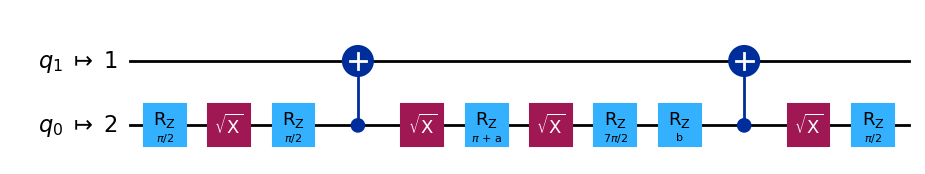

In [6]:
# 회로를 트랜스파일 해보세요.
#
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
from qiskit.transpiler import generate_preset_pass_manager

backend = FakeVigoV2()
pm = generate_preset_pass_manager(backend=backend)
isa_circuit = pm.run(circuit)

isa_circuit.draw('mpl')

In [7]:
# 트랜스파일한 회로에 맞게 관측가능량도 매핑을 해줘야 합니다.
observables = [
    [observable.apply_layout(isa_circuit.layout) for observable in observable_set]
    for observable_set in observables
]

이제 아래와 같이 pub을 구성하여 Estimator를 실행해보겠습니다.

In [8]:
# 아래의 pub을 실행한 결괏값의 형태는 (3, 100)이 됩니다.
# 현재 파라미터의 형태가 (100, 2), 관측가능량의 형태가 (3, 1)이라는 것을 잘 기억해두세요.
estimator_pub = (isa_circuit, observables, params)

# estimator를 설정하여 실행합니다.
estimator = Estimator(mode=backend)
job = estimator.run([estimator_pub])
result = job.result()

실행한 결과를 같이 확인해볼까요?

In [ ]:
#
result[0].data.evs


array([[ 8.30078125e-03,  6.25000000e-02,  1.27929688e-01,
         1.77246094e-01,  2.04101562e-01,  2.68554688e-01,
         3.49121094e-01,  3.84277344e-01,  4.31640625e-01,
         5.11230469e-01,  5.32714844e-01,  5.88867188e-01,
         6.42578125e-01,  6.48437500e-01,  6.98730469e-01,
         7.35839844e-01,  7.63671875e-01,  7.95898438e-01,
         8.34960938e-01,  8.46679688e-01,  8.64257812e-01,
         8.72558594e-01,  8.72558594e-01,  8.96972656e-01,
         9.06738281e-01,  9.07714844e-01,  9.05273438e-01,
         8.95507812e-01,  8.83789062e-01,  8.70117188e-01,
         8.69140625e-01,  8.34472656e-01,  8.14453125e-01,
         7.86132812e-01,  7.61230469e-01,  7.22167969e-01,
         6.75292969e-01,  6.66503906e-01,  6.14257812e-01,
         5.58593750e-01,  5.31738281e-01,  4.62402344e-01,
         4.18945312e-01,  3.55468750e-01,  3.07617188e-01,
         2.41210938e-01,  2.09472656e-01,  1.71386719e-01,
         7.95898438e-02, -4.88281250e-04, -4.83398438e-0

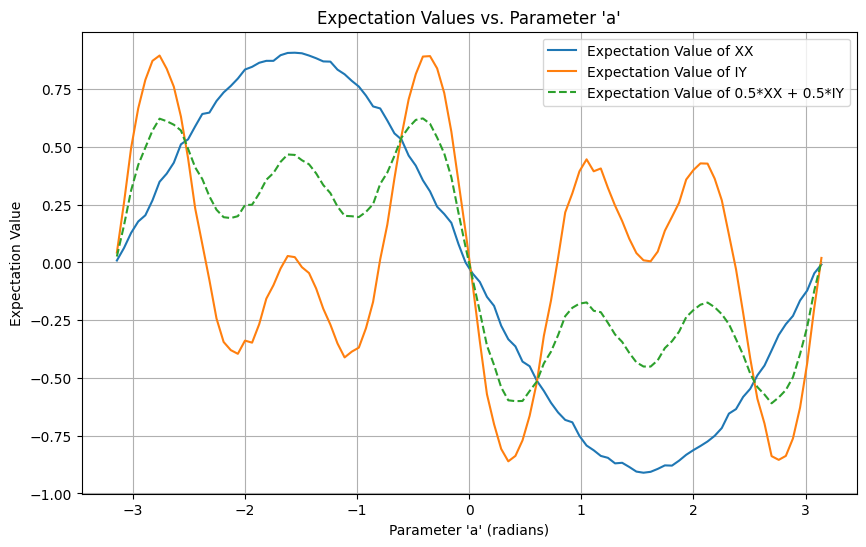

In [ ]:
evs = result[0].data.evs

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

x_axis_data = params[:, 0]

y_axis_data_obs0 = evs[0] # XX의 기댓값
y_axis_data_obs1 = evs[1] # IY의 기댓값
y_axis_data_obs2 = evs[2] # 0.5 XX + 0.5 IY의 기댓값

plt.plot(x_axis_data, y_axis_data_obs0, label="Expectation Value of XX")
plt.plot(x_axis_data, y_axis_data_obs1, label="Expectation Value of IY")
plt.plot(x_axis_data, y_axis_data_obs2, label="Expectation Value of 0.5*XX + 0.5*IY", linestyle='--')

plt.title("Expectation Values vs. Parameter 'a'")
plt.xlabel("Parameter 'a' (radians)")
plt.ylabel("Expectation Value")
plt.legend()
plt.grid(True)
plt.show()

# import matplotlib.pyplot as plt

# for i in range(3):
#     plt.plot(result[0].data.evs[i])
# plt.show()

In [19]:
result[0].data.stds

array([[0.01562446, 0.01559445, 0.01549661, 0.0153776 , 0.01529609,
        0.01505101, 0.01464184, 0.01442528, 0.01409446, 0.01342881,
        0.01322336, 0.01262859, 0.01197219, 0.01189481, 0.01117789,
        0.01058056, 0.01008757, 0.00945985, 0.00859858, 0.00831411,
        0.00786014, 0.00763296, 0.00763296, 0.00690759, 0.00658897,
        0.00655606, 0.00663796, 0.00695384, 0.00731071, 0.0077007 ,
        0.00772758, 0.00861015, 0.00906608, 0.00965715, 0.01013252,
        0.01080809, 0.01152421, 0.01164846, 0.01232977, 0.01296002,
        0.01323295, 0.01385422, 0.01418768, 0.0146045 , 0.01486735,
        0.01516364, 0.01527835, 0.01539381, 0.01557543, 0.015625  ,
        0.01560673, 0.01556915, 0.01545076, 0.01534643, 0.01502736,
        0.01473588, 0.01455749, 0.01411265, 0.01395972, 0.01342881,
        0.01298563, 0.01241218, 0.0118818 , 0.01143261, 0.01128123,
        0.01031764, 0.00952965, 0.00909813, 0.00854042, 0.00833834,
        0.00771416, 0.00778097, 0.00726731, 0.00

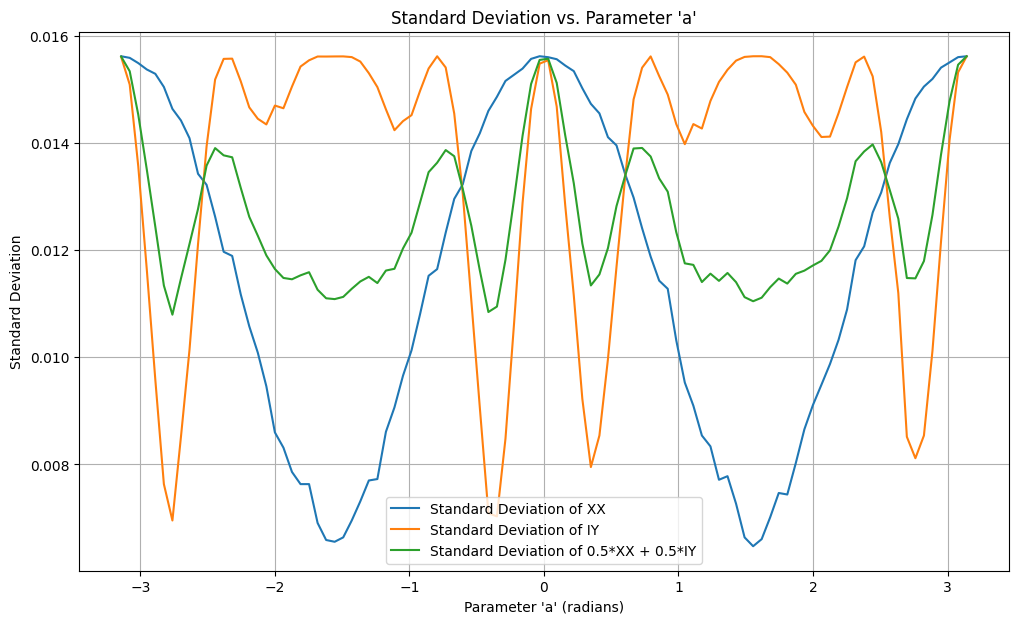

In [20]:
evs = result[0].data.evs
stds = result[0].data.stds

plt.figure(figsize=(12, 7))
x_axis_data = params[:, 0]

plt.plot(x_axis_data, stds[0], label=f"Standard Deviation of XX")
plt.plot(x_axis_data, stds[1], label=f"Standard Deviation of IY")
plt.plot(x_axis_data, stds[2], label=f"Standard Deviation of 0.5*XX + 0.5*IY")

plt.title("Standard Deviation vs. Parameter 'a'")
plt.xlabel("Parameter 'a' (radians)")
plt.ylabel("Standard Deviation")
plt.legend()
plt.grid(True)
plt.show()

### Broadcasting 규칙

PUB에 들어가는 변수들이 다양한 형태로 배열되어 있을 때 input을 구성하는 방식은 Numpy의 broadcasting 규칙을 따릅니다.자세한 설명은 [Qiskit 가이드](https://quantum.cloud.ibm.com/docs/en/guides/primitive-input-output)와 [NumPy broadcasting 규칙 문서](https://numpy.org/doc/stable/user/basics.broadcasting.html)를 참고하세요.

규칙:

*   입력값 배열은 서로 다른 차원과 크기를 가질 수 있습니다.
    *   결괏값의 배열은 입력값 배열의 각 차원에서 가장 큰 크기를 가져와 구성됩니다.
    *   누락된 차원이 있다면 해당 차원의 크기는 1로 가정합니다.
*   차원 크기는 가장 오른쪽(0차원)부터 순서대로 비교합니다.
*   두 배열의 각 차원의 크기는 서로 같거나 둘 중 하나가 1이어야 합니다.

broadcast 가능한 배열의 예시:

```text
A1     (1d array):      1
A2     (2d array):  3 x 5
Result (2d array):  3 x 5


A1     (3d array):  11 x 2 x 7
A2     (3d array):  11 x 1 x 7
Result (3d array):  11 x 2 x 7
```

broadcast가 되지 않는 배열의 예시:

```text
A1     (1d array):  5
A2     (1d array):  3

A1     (2d array):      2 x 1
A2     (3d array):  6 x 5 x 4 # 가운데 차원의 크기가 2였으면 broadcast가 가능했겠네요.
```

Qiskit primitive는 broadcast된 배열의 각 input을 가져와 결괏값을 계산합니다.

Broadcasting을 적용하는 주요 케이스에 대해 얘기해봅시다:

![This image illustrates several visual representations of array broadcasting](img/broadcasting.svg "Visual representation of broadcasting")



In [22]:
# Broadcast single observable
parameter_values = np.random.uniform(size=(5,))  # shape (5,)
observables = SparsePauliOp("ZZZ")  # shape ()
# >> pub result has shape (5,)

estimator_pub = (isa_circuit, observables, params)

# estimator를 설정하여 실행합니다.
estimator = Estimator(mode=backend)
job = estimator.run([estimator_pub])
result = job.result()
evs = result[0].data.evs

plt.figure(figsize=(8, 5))
plt.plot(parameter_values, evs, marker='o', linestyle='-')
plt.title("Broadcast: Single Observable vs. Multiple Parameters")
plt.xlabel("Parameter 'p' value")
plt.ylabel("Expectation Value of ZZZ")
plt.grid(True)
plt.show()

ValueError: The number of qubits of the circuit (5) does not match the number of qubits of the ()-th observable (3).

In [ ]:
# Zip
parameter_values = np.random.uniform(size=(5,))  # shape (5,)
observables = [
    SparsePauliOp(pauli) for pauli in ["III", "XXX", "YYY", "ZZZ", "XYZ"]
]  # shape (5,)
# >> pub result has shape (5,)



In [ ]:
# Outer/Product
parameter_values = np.random.uniform(size=(1, 6))  # shape (1, 6)
observables = [
    [SparsePauliOp(pauli)] for pauli in ["III", "XXX", "YYY", "ZZZ"]
]  # shape (4, 1)
# >> pub result has shape (4, 6)



In [ ]:
# Standard nd generalization
parameter_values = np.random.uniform(size=(3, 6))  # shape (3, 6)
observables = [
    [
        [SparsePauliOp(["XII"])],
        [SparsePauliOp(["IXI"])],
        [SparsePauliOp(["IIX"])],
    ],
    [
        [SparsePauliOp(["ZII"])],
        [SparsePauliOp(["IZI"])],
        [SparsePauliOp(["IIZ"])],
    ],
]
# >> pub result has shape (2, 3, 1)

위에서 주어진 케이스를 실행해보고 앞에서와 같이 그래프로 나타내봅시다.

In [ ]:
#